In [8]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np



import seaborn as sns

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from scipy import signal

from sklearn.mixture import GaussianMixture

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM

from scipy.stats import probplot
from scipy.stats import normaltest

from joblib import dump, load

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Variational_AE import create_autoencoder as create_conv_vae
from ML_Train.Convolutional_AE import create_autoencoder as create_conv_ae
from ML_Train.Variational_Vanilla_AE import create_autoencoder as create_vanilla_vae
from ML_Train.CNN_Classifier import create_autoencoder as create_hybrid_cnn_ae

keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# mse = keras.metrics.mean_squared_error(all_outputs,input_data)


In [25]:
trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

first_good_train = np.argwhere(Y_train[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test[:,0] == 0).flatten()[0]

X_train = fft_from_vib(X_train[:,:-1])[:,1:]
X_test = fft_from_vib(X_test[:,:-1])[:,1:]


X_train_healthy = X_train[first_good_train:,:]
X_valid_healthy = X_test[first_good_test:,:]
X_train_unhealthy = X_train[:first_good_train,:]
X_valid_unhealthy = X_test[:first_good_test,:]

np.random.shuffle(X_train_healthy)
np.random.shuffle(X_valid_healthy)
np.random.shuffle(X_train_unhealthy)
np.random.shuffle(X_valid_unhealthy)


In [59]:
def fft_from_vib(values):
    _,amps = signal.welch(values, fs=20e3, nperseg=2048, scaling='spectrum')
    lin_amps = lin_log_interp(amps)
    return lin_amps


def lin_log_interp(fft_features):
    '''
    Scale the fft features from the logarithmic axis to be approximately on 
    the interval from 0 to 1
    '''
    
    # Minimum exponent we expect to see in the data
    minimum = -12
    
    # Maximum exponent we expect to see
    maximum = 0
    
    # Number of points to use for interpolation
    numpoints = 1000
    
    # Map the logarithmic x-axis to a linear y-axis
    x = np.logspace(minimum,maximum,numpoints)
    y = np.linspace(0,1,numpoints)

    # Return the interpolated valuess
    return np.interp(np.log10(fft_features),np.log10(x),y)

In [60]:
10000/2048

4.8828125

In [61]:
X_train_healthy.shape

(150, 2048)

In [62]:
pca = PCA(n_components=5)
X_condensed_pca = pca.fit_transform(np.squeeze(X_train_healthy))
# X_reconstructed_pca = pca.inverse_transform(X_condensed_pca)
# mse = keras.metrics.mean_squared_error(X_reconstructed_pca,np.squeeze(X_train_healthy))

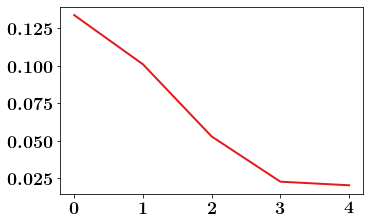

In [63]:
plt.plot(pca.explained_variance_ratio_)

In [74]:
# estimators = [('gmm', OneClassSVM())]
estimators = [('reduce_dim', PCA(n_components=64)), ('gmm', GaussianMixture())]

fft_size = -1

pipe = Pipeline(estimators)
pipe.fit(np.squeeze(X_train_healthy)[:,:fft_size])


Pipeline(memory=None,
         steps=[('reduce_dim',
                 PCA(copy=True, iterated_power='auto', n_components=64,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('gmm',
                 GaussianMixture(covariance_type='full', init_params='kmeans',
                                 max_iter=100, means_init=None, n_components=1,
                                 n_init=1, precisions_init=None,
                                 random_state=None, reg_covar=1e-06, tol=0.001,
                                 verbose=0, verbose_interval=10,
                                 warm_start=False, weights_init=None))],
         verbose=False)

In [75]:
score_train_gmm_healthy = pipe.score_samples(np.squeeze(X_train_healthy)[:,:fft_size])
score_valid_gmm_healthy = pipe.score_samples(np.squeeze(X_valid_healthy)[:,:fft_size])
score_train_gmm_unhealthy = pipe.score_samples(np.squeeze(X_train_unhealthy)[:,:fft_size])
score_valid_gmm_unhealthy = pipe.score_samples(np.squeeze(X_valid_unhealthy)[:,:fft_size])

norm_train_gmm_healthy = np.log(np.abs(score_train_gmm_healthy-1.1*np.amax(score_train_gmm_healthy)))
mean_train_gmm_healthy = np.mean(norm_train_gmm_healthy)
std_train_gmm_healthy = np.std(norm_train_gmm_healthy)
norm_train_gmm_healthy = (norm_train_gmm_healthy - mean_train_gmm_healthy) / std_train_gmm_healthy

norm_valid_gmm_healthy = np.log(np.abs(score_valid_gmm_healthy-1.1*np.amax(score_train_gmm_healthy)))
norm_valid_gmm_healthy = (norm_valid_gmm_healthy - mean_train_gmm_healthy) / std_train_gmm_healthy

norm_train_gmm_unhealthy = np.log(np.abs(score_train_gmm_unhealthy-1.1*np.amax(score_train_gmm_healthy)))
norm_train_gmm_unhealthy = (norm_train_gmm_unhealthy - mean_train_gmm_healthy) / std_train_gmm_healthy

norm_valid_gmm_unhealthy = np.log(np.abs(score_valid_gmm_unhealthy-1.1*np.amax(score_train_gmm_healthy)))
norm_valid_gmm_unhealthy = (norm_valid_gmm_unhealthy - mean_train_gmm_healthy) / std_train_gmm_healthy


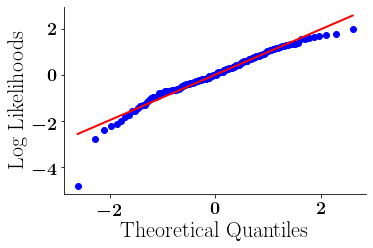

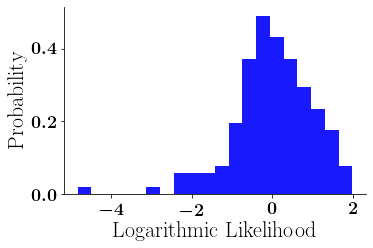

In [76]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

res = probplot(norm_train_gmm_healthy, plot=ax)
ax.set_title("")
plt.xlabel(r'{Theoretical Quantiles}')
plt.ylabel(r'{Log Likelihoods}')
# plt.savefig('figures/PCA-GMM_64_NormalTest.png',transparent=True)     
plt.show()

num_col = 2
legend_loc = 'upper right'
transparent = False

plt.figure(figsize=(6,4))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(norm_train_gmm_healthy, 20, density=True, facecolor='b', alpha=0.90,label='Nominal')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'{Logarithmic Likelihood}')
plt.ylabel(r'{Probability}')
# ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(not transparent)).get_frame().set_edgecolor('k')
# plt.title('Histogram of IQ')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.axis([40, 160, 0, 0.03])
plt.grid(False)
# plt.savefig('figures/PCA-GMM_64_Histogram_Train_Healthy.png',transparent=True)     
plt.show()



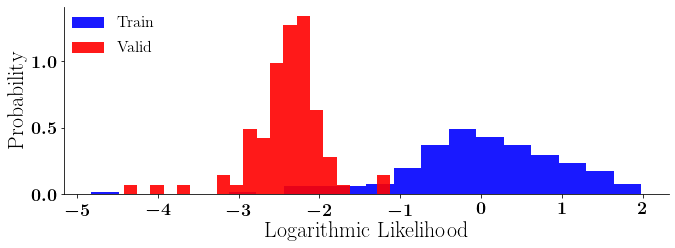

In [77]:

num_col = 1
legend_loc = 'upper left'
transparent = False

plt.figure(figsize=(12,4))
ax = plt.gca()

test_valid = np.log(np.abs(score_valid_gmm_healthy-1.1*np.amax(score_train_gmm_healthy))) 
test_train = np.log(np.abs(score_train_gmm_healthy-1.1*np.amax(score_train_gmm_healthy)))

test_valid = (test_valid - np.mean(test_train)) / np.std(test_train)
test_train = (test_train - np.mean(test_train)) / np.std(test_train)


# the histogram of the data
n, bins, patches = plt.hist(test_train, 20, density=True, facecolor='b', alpha=0.90,label='Train')
n, bins, patches = plt.hist(test_valid, 20, density=True, facecolor='r', alpha=0.90,label='Valid')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'{Logarithmic Likelihood}')
plt.ylabel(r'{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(transparent)).get_frame().set_edgecolor('k')
# plt.title('Histogram of IQ')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.axis([40, 160, 0, 0.03])
plt.grid(False)
# plt.savefig('figures/PCA-GMM_64_Histogram_Train_Compare.png',transparent=True)     
plt.show()

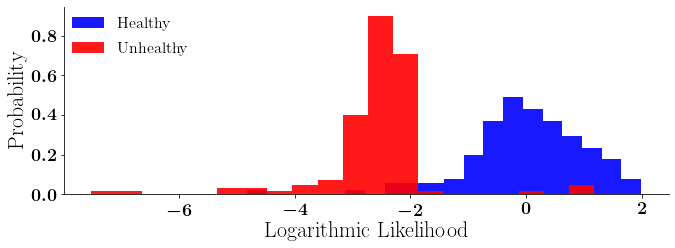

In [78]:

num_col = 1
legend_loc = 'upper left'
transparent = False

plt.figure(figsize=(12,4))
ax = plt.gca()
# the histogram of the data
n, bins, patches = plt.hist(norm_train_gmm_healthy, 20, density=True, facecolor='b', alpha=0.90,label='Healthy')
n, bins, patches = plt.hist(norm_train_gmm_unhealthy, 20, density=True, facecolor='r', alpha=0.90,label='Unhealthy')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xlabel(r'{Logarithmic Likelihood}')
plt.ylabel(r'{Probability}')
ax.legend(ncol=num_col,loc=legend_loc,framealpha=float(transparent)).get_frame().set_edgecolor('k')
# plt.title('Histogram of IQ')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
# plt.axis([40, 160, 0, 0.03])
plt.grid(False)
# plt.savefig('figures/PCA-GMM_64_Histogram_Train_Compare.png',transparent=True)     
plt.show()
